In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
import seaborn as sb
import quantstats as qs
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import objective_functions
from pypfopt.base_optimizer import BaseConvexOptimizer
from pypfopt import DiscreteAllocation
from datetime import date


###Some functions

In [ ]:
def get_stock(stocks):
  pf=pd.DataFrame()
  for element in stocks:
    pf[element]= wb.DataReader(element,data_source='yahoo')['Adj Close']
  return pf

def last_price(stocks):
  pf=pd.DataFrame()
  for element in stocks:
    pf[element]=wb.DataReader(element,data_source='yahoo')['Adj Close']
  pf=pf.iloc[-1]
  return pf

def pct_returns(stocks):
  change= stocks.pct_change()
  return change.dropna()

def pct_ret_log(stocks):
  change= np.log(stocks/stocks.shift(1))
  return change.dropna()

def port_w(lista):
  media= expected_returns.mean_historical_return(lista)
  cov= risk_models.risk_matrix(lista, method='sample_cov')
  ef=EfficientFrontier(media,cov)
  vol=float(input('Máxima volatilidad histórica del portfolio: '))
  return plotting.plot_weights(ef.efficient_risk(vol))

In [ ]:
#Stocks ordered by sector
tech= ['MSFT','V','GOOGL','AMD','MELI','FB','AMZN','T','VZ','NVDA','AAPL','ADBE','DIS']
industrial=['GE','TM','JNJ','HD','X','KO','WMT','PG','PFE','BA','DE','CAT','LMT','VALE','MRK','WBA','UNH','AVY']
financial=['GS','C','JPM','V','WFC']
commodities=['GOLD','XOM','CVX','AGRO','VIST','HAL','TS']
growth=['SHOP','BABA','CRM']
a_stocks= tech+industrial+commodities+financial+growth
a_stocks.sort()
#Collecting price history and returns
l_stocks=get_stock(a_stocks)
pct_stocks=pct_ret_log(l_stocks)

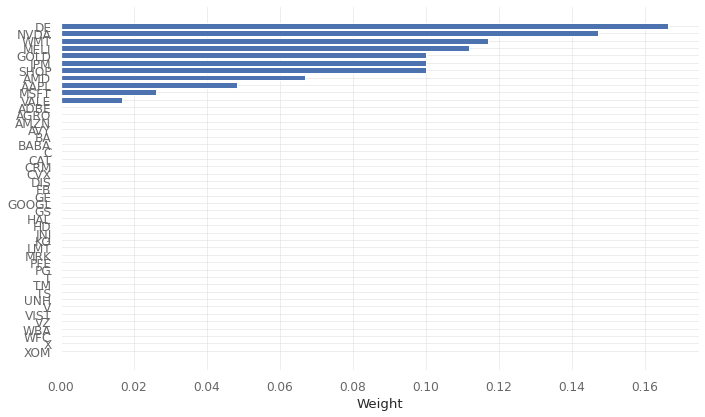

In [ ]:
#Set min and max value per sector
sector_mapper=dict()

for stock in a_stocks:
  if stock in tech:
    sector_mapper.update({stock:'tech'})
  elif stock in industrial:
    sector_mapper.update({stock:'industrial'})
  elif stock in commodities:
    sector_mapper.update({stock:'commodities'})
  elif stock in financial:
    sector_mapper.update({stock:'financial'})
  elif stock in growth:
    sector_mapper.update({stock:'growth'})

sector_lower={'tech':0.10,'industrial':0.10,'commodities':0.10,'financial':0.10}
sector_upper={'tech':0.4,'industrial':0.4, 'commodities':0.4,'financial':0.4,'growth':0.1}

#Creating EfficientFrontier
media= expected_returns.mean_historical_return(l_stocks)
cov= risk_models.risk_matrix(l_stocks, method='sample_cov')
ef=EfficientFrontier(media,cov)
BaseConvexOptimizer.add_sector_constraints(ef,sector_mapper,sector_lower,sector_upper)
#If u want to diversify some more, just uncomment the following line
#ef.add_objective(objective_functions.L2_reg, gamma=0.1)

#For max sharpe
plotting.plot_weights(ef.max_sharpe())

#For an specific level of volatility, for example, 20%
#plotting.plot_weights(ef.efficient_risk(0.2))

In [ ]:
##Return, volatility and sharpe ratio
ef.portfolio_performance(verbose=True)

Expected annual return: 50.8%
Annual volatility: 24.8%
Sharpe Ratio: 1.97


(0.5076647127254691, 0.24770832563012093, 1.9687053775239352)

In [ ]:
#Weights of optimized portfolio, per stock (%)
w=dict(ef.clean_weights())

weights_def=dict()

for key,value in w.items():
  if value>0.001:
    weights_def.update({key:value})

weights_def


{'AAPL': 0.04823,
 'AMD': 0.06695,
 'DE': 0.16635,
 'GOLD': 0.1,
 'JPM': 0.1,
 'MELI': 0.1117,
 'MSFT': 0.02614,
 'NVDA': 0.14698,
 'SHOP': 0.1,
 'VALE': 0.01669,
 'WMT': 0.11695}

In [ ]:
#Taking cedears from comafi's page in order to extract the ratios between USA stock's and argy's cedears
url= 'https://www.comafi.com.ar/Multimedios/otros/7279.xlsx'
cedears= pd.read_excel(url,header=15,usecols='C,H')
#cedears.columns=cedears.columns.str.replace(' ','')
cedears.dropna(inplace=True)
cedears=cedears.applymap((lambda x: "".join(x.split()) if type(x) is str else x ))
cedears.set_index('Identificación Mercado', inplace=True)
cedears

,Ratio Cedear/Acción ó ADR
Identificación Mercado,
ABT,4:1
HWM,1:1
AEG,1:1
MO,4:1
ACH,1:1
...,...
EFX,16:1
SQ,20:1
SHOP,107:1


In [ ]:
ratios=dict()
for key,value in weights_def.items():
  ratios.update({key:cedears.loc[key][0][:-2]})
ratios

{'AAPL': '10',
 'AMD': '1',
 'DE': '10',
 'GOLD': '1',
 'JPM': '5',
 'MELI': '60',
 'MSFT': '10',
 'NVDA': '24',
 'SHOP': '107',
 'VALE': '2',
 'WMT': '6'}

In [ ]:
for key,value in ratios.items():
  ratios.update({key:float(value)})

ratios

{'AAPL': 10.0,
 'AMD': 1.0,
 'DE': 10.0,
 'GOLD': 1.0,
 'JPM': 5.0,
 'MELI': 60.0,
 'MSFT': 10.0,
 'NVDA': 24.0,
 'SHOP': 107.0,
 'VALE': 2.0,
 'WMT': 6.0}

In [ ]:
prices=last_price(a_stocks)
prices['AMZN']

3503.820068359375

In [ ]:
#Calculating price per share (USD) based on argentinian's cedears ratio
usd_cedear=dict()
for key,value in ratios.items():
  usd_cedear.update({key:round(prices[key]/value,2)})

usd_cedear


{'AAPL': 13.37,
 'AMD': 83.82,
 'DE': 34.78,
 'GOLD': 20.96,
 'JPM': 30.22,
 'MELI': 25.55,
 'MSFT': 26.53,
 'NVDA': 31.76,
 'SHOP': 14.02,
 'VALE': 11.4,
 'WMT': 22.66}

In [ ]:
#Calculates number of shares based on weight and money
#IMPORTANT: Take care of spread between MEP and CCL values. The capital needed could be a little bit higher than expected
shares=dict()
capital=float(input('Capital a invertir(USD): '))
for key,value in weights_def.items():
  if key in usd_cedear:
    a=capital/usd_cedear[key]*weights_def[key]
    shares.update({key:round(a,0)})

print(f'\nCantidad de stocks a comprar para el armado de la cartera: \n')
for key,value in shares.items():
  print(key,'-->',int(value))

Capital a invertir(USD): 2500

Cantidad de stocks a comprar para el armado de la cartera: 

AAPL --> 9
AMD --> 2
DE --> 12
GOLD --> 12
JPM --> 8
MELI --> 11
MSFT --> 2
NVDA --> 12
SHOP --> 18
VALE --> 4
WMT --> 13


In [ ]:
#Import last prices for argentinian cedears (ARS).
cedears = list()
for stock in a_stocks:
  cedears.append(stock+'.BA')

cedears[2]='GOOGL.BA'
#cedears
cedears=last_price(cedears)
cedears

#To be continued...

MSFT.BA      4193.0
V.BA         6425.5
GOOGL.BA     6871.0
AMD.BA      26569.5
MELI.BA      3642.0
FB.BA        6845.0
AMZN.BA      3763.5
GE.BA        2266.5
TM.BA        6012.5
T.BA         1609.5
JNJ.BA       5495.5
HD.BA        6380.5
X.BA         1501.0
KO.BA        1847.5
WMT.BA       3843.0
VZ.BA        4749.5
PG.BA        4488.5
PFE.BA       3307.0
GOLD.BA      3828.5
XOM.BA       2077.5
HMY.BA        783.0
TOT.BA       2685.0
CVX.BA       2232.0
AGRO.BA        27.5
Name: 2021-06-09 00:00:00, dtype: float64